Project Title: Stock Market Data Analysis and Trend Forecasting using PySpark

Step 1: Project Setup and Data Understanding

Phase 1: Project Setup and Data Understanding

In [30]:
!pip install pyspark

In [32]:
import findspark
findspark.init()

In [34]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ICICI Analysis").getOrCreate()
sc = spark.sparkContext

In [36]:
file_path = r'C:\Users\tanma\OneDrive\Desktop\PySpark Project\ICICIBANK.csv'

In [38]:
df_icici = spark.read.csv(file_path, header = True, inferSchema = True)

1. Basic Data Exploration

a) Check the Schema

In [40]:
df_icici.printSchema()

root
 |-- Price: timestamp (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)



b) Show Initial Rows

In [51]:
df_icici = df_icici.withColumnRenamed('Price','Date')
df_icici.show(10)


+-------------------+-----------+-----------+-----------+-----------+-----------+-------+
|               Date|  Adj Close|      Close|       High|        Low|       Open| Volume|
+-------------------+-----------+-----------+-----------+-----------+-----------+-------+
|2002-07-01 05:30:00|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|
|2002-07-02 05:30:00|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354|
|2002-07-03 05:30:00| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|
|2002-07-04 05:30:00|19.43779373|27.39090919|28.79999924| 27.0363636|28.18181801|3896601|
|2002-07-05 05:30:00|19.63778496|27.67272758|27.86363602|26.94545364|27.09090805|3261038|
|2002-07-08 05:30:00|19.33456802|27.24545479|27.89090919|27.17272758|27.88181877|2092667|
|2002-07-09 05:30:00| 19.2249012|27.09090805|27.68181801| 26.9272728|27.39999962|1026800|
|2002-07-10 05:30:00|19.15393829|26.99090958|27.27272606|26.90909004|27.23636246|1513611|
|2002-07-1

c) Summary Statistics

In [44]:
df_icici.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|         Adj Close|             Close|             High|               Low|              Open|              Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              5555|              5555|             5555|              5555|              5555|                5555|
|   mean|292.39948505289783|312.10546517288424|316.0452045315438| 308.1061106533795|312.20347511738976| 1.899552776111611E7|
| stddev| 290.8242445086597| 289.2001672247756| 291.513701024517|286.73874632277324|289.08091027781444|1.8255547861005865E7|
|    min|       14.26384544|       20.10000038|      21.45454407|       19.89090919|       20.27272606|                   0|
|    max|       1338.449951|       1338.449951|      1362.349976|       1316.900024|            1333.0|           286857658|


1. Register the DataFrame as a SQL temporary view

In [53]:
df_icici.createOrReplaceTempView('icici_stock')

2. Check for Null Values

In [56]:
spark.sql("""
SELECT
SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS Date_NullCount,
SUM(CASE WHEN Open IS NULL THEN 1 ELSE 0 END) AS Open_NullCount,
SUM(CASE WHEN High IS NULL THEN 1 ELSE 0 END) AS High_NullCount,
SUM(CASE WHEN Low IS NULL THEN 1 ELSE 0 END) AS Low_NullCount,
SUM(CASE WHEN Close IS NULL THEN 1 ELSE 0 END) AS Close_NullCount,
SUM(CASE WHEN Volume IS NULL THEN 1 ELSE 0 END) AS Volume_NullCount
FROM icici_stock
""").show()

+--------------+--------------+--------------+-------------+---------------+----------------+
|Date_NullCount|Open_NullCount|High_NullCount|Low_NullCount|Close_NullCount|Volume_NullCount|
+--------------+--------------+--------------+-------------+---------------+----------------+
|             0|             0|             0|            0|              0|               0|
+--------------+--------------+--------------+-------------+---------------+----------------+



3. Summary Statistics by SQL

In [58]:
spark.sql("""SELECT 
MIN(Close) AS min_close,
MAX(Close) AS max_close,
AVG(Close) AS avg_close,
STDDEV(Close) AS stddev_close
FROM icici_stock""").show()

+-----------+-----------+------------------+-----------------+
|  min_close|  max_close|         avg_close|     stddev_close|
+-----------+-----------+------------------+-----------------+
|20.10000038|1338.449951|312.10546517288424|289.2001672247756|
+-----------+-----------+------------------+-----------------+



1.5 Data Quality Checks

a) Check for Duplicates

In [62]:
unique_count = df_icici.count() - df_icici.dropDuplicates().count()
print(unique_count)

0


Phase 2: Data Cleaning and Preparation

a) Drop rows with missing values and drop duplicates rows.

In [66]:
df_icici = df_icici.dropna().dropDuplicates()
df_icici.count()

5555

2.3 Add New Columns for Analysis

a) Calculate Daily Returns

In [70]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

window_spec = Window.orderBy('Date')


In [72]:
df_icici = df_icici.withColumn("Prev_Close", lag("Close").over(window_spec))
df_icici = df_icici.withColumn("Daily_Return", ((col("Close") - col("Prev_Close")) / col("Prev_Close")) * 100)

df_icici.show(10)

+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+
|               Date|  Adj Close|      Close|       High|        Low|       Open| Volume| Prev_Close|        Daily_Return|
+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+
|2002-07-01 05:30:00|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|       NULL|                NULL|
|2002-07-02 05:30:00|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354|25.12727165|  6.4399476494695325|
|2002-07-03 05:30:00| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|26.74545479|   5.030586582147252|
|2002-07-04 05:30:00|19.43779373|27.39090919|28.79999924| 27.0363636|28.18181801|3896601|28.09090805| -2.4919054191984404|
|2002-07-05 05:30:00|19.63778496|27.67272758|27.86363602|26.94545364|27.09090805|3261038|27.39090919|  1.0288756318570438|
|2002-07-08 05:3

b) Calculate Moving Averages for 50 days and 200 days Window.

In [75]:
window_50 = Window.orderBy('date').rowsBetween(-49,0)
df_icici = df_icici.withColumn('Mov_Avg_50',avg('Close').over(window_50))

window_200 = Window.orderBy('date').rowsBetween(-199,0)
df_icici = df_icici.withColumn('Mov_Avg_200',avg('Close').over(window_200))
df_icici.show(5)

+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-----------+-------------------+------------------+------------------+
|               Date|  Adj Close|      Close|       High|        Low|       Open| Volume| Prev_Close|       Daily_Return|        Mov_Avg_50|       Mov_Avg_200|
+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-----------+-------------------+------------------+------------------+
|2002-07-01 05:30:00|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|       NULL|               NULL|       25.12727165|       25.12727165|
|2002-07-02 05:30:00|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354|25.12727165| 6.4399476494695325|       25.93636322|       25.93636322|
|2002-07-03 05:30:00| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|26.74545479|  5.030586582147252|26.654544830000003|26.654544830000003|
|2002-07-04 05:30:00|19.43779373|27.3909

2.4 Remove Unwanted Columns

In [78]:
df_icici = df_icici.drop('Prev_Close')
df_icici.show(5)

+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-------------------+------------------+------------------+
|               Date|  Adj Close|      Close|       High|        Low|       Open| Volume|       Daily_Return|        Mov_Avg_50|       Mov_Avg_200|
+-------------------+-----------+-----------+-----------+-----------+-----------+-------+-------------------+------------------+------------------+
|2002-07-01 05:30:00|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|               NULL|       25.12727165|       25.12727165|
|2002-07-02 05:30:00|18.97974968|26.74545479|27.63636208|25.23636246|25.45454407|5546354| 6.4399476494695325|       25.93636322|       25.93636322|
|2002-07-03 05:30:00| 19.9345417|28.09090805|28.18181801|26.64545441|26.72727203|5745267|  5.030586582147252|26.654544830000003|26.654544830000003|
|2002-07-04 05:30:00|19.43779373|27.39090919|28.79999924| 27.0363636|28.18181801|3896601|-2.4919054191984404|   

2.5 Final Data Check

In [81]:
df_icici.printSchema()
df_icici.show(10)

root
 |-- Date: timestamp (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Daily_Return: double (nullable = true)
 |-- Mov_Avg_50: double (nullable = true)
 |-- Mov_Avg_200: double (nullable = true)

+-------------------+-----------+-----------+-----------+-----------+-----------+-------+--------------------+------------------+------------------+
|               Date|  Adj Close|      Close|       High|        Low|       Open| Volume|        Daily_Return|        Mov_Avg_50|       Mov_Avg_200|
+-------------------+-----------+-----------+-----------+-----------+-----------+-------+--------------------+------------------+------------------+
|2002-07-01 05:30:00|17.83141708|25.12727165|25.81818008|24.81818008|25.41818047|2047540|                NULL|       25.12727165|       25.12727165|
|2002-

Phase 3: Exploratory Data Analysis (EDA)

3.1 Summary Statistics

In [85]:
df_icici.createOrReplaceTempView("icici_stock")
df_icici.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+-----------------+------------------+
|summary|         Adj Close|             Close|             High|               Low|              Open|              Volume|       Daily_Return|       Mov_Avg_50|       Mov_Avg_200|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+-----------------+------------------+
|  count|              5555|              5555|             5555|              5555|              5555|                5555|               5554|             5555|              5555|
|   mean|292.39948505289783|312.10546517288424|316.0452045315438| 308.1061106533795|312.20347511738976| 1.899552776111611E7|0.09944201361641007|306.6134454883574|290.90172949417234|
| stddev| 290.8242445086597| 289.2001672247756| 291.513701024517|286.73874632277324|289.08

Using PySparkSQL:

In [88]:
spark.sql(""" SELECT MAX(Close) AS Max_Close,
MIN(CLose) AS Min_Close,
AVG(Close) AS Avg_Close,
STDDEV(Close) AS StdDev_Close 
FROM icici_stock""").show()

spark.sql("""SELECT MAX(Volume) AS Max_Volume,
MIN(Volume) AS Min_Volume,
AVG(Volume) AS Avg_Volume,
STDDEV(Volume) AS StdDev_Volume 
FROM icici_stock""").show()

+-----------+-----------+------------------+-----------------+
| max(Close)| min(CLose)|        avg(Close)|    stddev(Close)|
+-----------+-----------+------------------+-----------------+
|1338.449951|20.10000038|312.10546517288344|289.2001672247759|
+-----------+-----------+------------------+-----------------+

+-----------+-----------+-------------------+-------------------+
|max(Volume)|min(Volume)|        avg(Volume)|     stddev(Volume)|
+-----------+-----------+-------------------+-------------------+
|  286857658|          0|1.899552776111611E7|1.825554786100588E7|
+-----------+-----------+-------------------+-------------------+



3.2 Analyze Daily Returns

In [91]:
spark.sql("""
SELECT
AVG(Daily_Return) AS Avg_Daily_Return,
STDDEV(Daily_Return) AS StdDev_Daily_Return,
MIN(Daily_Return) AS Min_Daily_Return,
MAX(Daily_Return) AS Max_Daily_Return 
FROM icici_stock
""").show()

+-------------------+--------------------+-------------------+------------------+
|  avg(Daily_Return)|stddev(Daily_Return)|  min(Daily_Return)| max(Daily_Return)|
+-------------------+--------------------+-------------------+------------------+
|0.09944201361641007|   2.412881170179866|-19.856752339393942|23.038103857646927|
+-------------------+--------------------+-------------------+------------------+



3.3 Trend Analysis with Moving Averages

a) Calculate Rolling Averages

In [95]:
spark.sql("""
SELECT
Date,
Close,
Mov_Avg_50,
Mov_Avg_200,
CASE WHEN Mov_Avg_50 > Mov_Avg_200 THEN 'Uptrend' ELSE 'Downtrend' END AS Trend
FROM icici_stock
ORDER BY Date
""").show(10)

+-------------------+-----------+------------------+------------------+---------+
|               Date|      Close|        Mov_Avg_50|       Mov_Avg_200|    Trend|
+-------------------+-----------+------------------+------------------+---------+
|2002-07-01 05:30:00|25.12727165|       25.12727165|       25.12727165|Downtrend|
|2002-07-02 05:30:00|26.74545479|       25.93636322|       25.93636322|Downtrend|
|2002-07-03 05:30:00|28.09090805|26.654544830000003|26.654544830000003|Downtrend|
|2002-07-04 05:30:00|27.39090919|       26.83863592|       26.83863592|Downtrend|
|2002-07-05 05:30:00|27.67272758|27.005454252000003|27.005454252000003|Downtrend|
|2002-07-08 05:30:00|27.24545479| 27.04545434166667| 27.04545434166667|Downtrend|
|2002-07-09 05:30:00|27.09090805| 27.05194772857143| 27.05194772857143|Downtrend|
|2002-07-10 05:30:00|26.99090958|       27.04431796|       27.04431796|Downtrend|
|2002-07-11 05:30:00|26.79090881|27.016161387777778|27.016161387777778|Downtrend|
|2002-07-12 05:3

3.4 Volume Analysis

In [98]:
spark.sql(""" SELECT date, 
Close, 
Volume, 
Daily_Return 
FROM icici_stock 
ORDER BY Volume DESC""").show(10)

+-------------------+-----------+---------+--------------------+
|               date|      Close|   Volume|        Daily_Return|
+-------------------+-----------+---------+--------------------+
|2019-11-26 05:30:00|510.7000122|286857658|   2.591407134622675|
|2009-03-06 05:30:00|48.93636322|277252228|-0.33326935865382273|
|2008-10-10 05:30:00|66.11817932|196556492| -19.856752339393942|
|2009-03-31 05:30:00|60.50909042|188785256|   -1.56758668422299|
|2011-11-30 05:30:00|129.5363617|175381222| -2.9293528598080525|
|2009-03-17 05:30:00|58.79999924|175129680|  0.1858701788199187|
|2008-10-13 05:30:00|77.30000305|167420044|  16.911874835333872|
|2009-05-19 05:30:00|137.4818115|164921339|   6.936784808809662|
|2009-03-12 05:30:00|51.66363525|150544240|   8.062361131387002|
|2009-04-27 05:30:00|85.00908661|147298052|   7.705597455223141|
+-------------------+-----------+---------+--------------------+
only showing top 10 rows



3.5 Seasonal Patterns Analysis

Monthly Average Close Price and Volume

In [102]:
spark.sql("""
SELECT
MONTH(Date) AS Month,
AVG(Close) AS Avg_Monthly_Close,
AVG(Volume) AS Avg_Monthly_Volume
FROM icici_stock
GROUP BY MONTH(Date)
ORDER BY Month
""").show()

+-----+------------------+--------------------+
|Month| Avg_Monthly_Close|  Avg_Monthly_Volume|
+-----+------------------+--------------------+
|    1|311.88765613250007| 1.824935280387931E7|
|    2|313.46152482630475| 1.805872689838337E7|
|    3| 295.2848237876993| 2.353100746017699E7|
|    4| 301.1020834953683| 2.237189463182898E7|
|    5|310.45393119755863|2.0704726453961454E7|
|    6|309.11974520747873|1.7384882888888888E7|
|    7| 307.9801058479606| 1.766125538019802E7|
|    8|314.32920311975255| 1.794891115257732E7|
|    9| 324.9658654297053| 1.787948482736842E7|
|   10| 329.1296669904948|1.9384070176344085E7|
|   11| 320.6251954350331|1.9299934838137474E7|
|   12|305.82673960119394| 1.607342941151386E7|
+-----+------------------+--------------------+



3.6 Identify High and Low Volatility Periods

Identify Volatile Days

In [106]:
spark.sql(""" SELECT Date,
Close,
Volume,
Daily_Return
FROM icici_stock
ORDER BY ABS(Daily_Return) DESC""").show(10)

+-------------------+-----------+---------+-------------------+
|               date|      close|   volume|       Daily_Return|
+-------------------+-----------+---------+-------------------+
|2009-05-18 05:30:00|128.5636292|   354381| 23.038103857646927|
|2008-10-10 05:30:00|66.11817932|196556492|-19.856752339393942|
|2020-03-23 05:30:00|      284.0| 56867949|  -17.8478478514789|
|2008-10-13 05:30:00|77.30000305|167420044| 16.911874835333872|
|2008-10-31 05:30:00|       72.5| 77742401|  15.46257471663437|
|2017-10-25 05:30:00|305.7000122|123615362| 14.687685684448567|
|2008-10-24 05:30:00|56.94545364| 92378528|-14.379438145166255|
|2003-08-21 05:30:00| 32.4272728| 76284219| 13.852541484163897|
|2020-04-07 05:30:00|326.1000061| 57661076| 13.762432597072504|
|2008-03-17 05:30:00|138.1727295| 35297707|  -13.3416916736623|
+-------------------+-----------+---------+-------------------+
only showing top 10 rows



Phase 4: Correlation and Trend Analysis

4.1 Correlation Analysis

a) Correlation between Close Price and Volume

In [111]:
spark.sql("""
SELECT corr(Close, Volume) AS Close_Volume_Correlation
FROM icici_stock
""").show()

+------------------------+
|Close_Volume_Correlation|
+------------------------+
|    -0.04218308259364...|
+------------------------+



b) Correlation Among Other Variables

In [114]:
spark.sql("""
SELECT
corr(Open, Close) AS Open_Close_Correlation,
corr(High, Close) AS High_Close_Correlation,
corr(Low, Close) AS Low_Close_Correlation,
corr(Volume, Close) AS Volume_Close_Correlation
FROM icici_stock
""").show()

+----------------------+----------------------+---------------------+------------------------+
|Open_Close_Correlation|High_Close_Correlation|Low_Close_Correlation|Volume_Close_Correlation|
+----------------------+----------------------+---------------------+------------------------+
|     0.999785934516559|    0.9999106379302584|   0.9999018103450272|    -0.04218308259364835|
+----------------------+----------------------+---------------------+------------------------+



4.2 Trend Analysis with Moving Averages

a) Crossovers in Moving Averages

In [118]:
spark.sql("""
SELECT
Date,
Close,
Mov_Avg_50,
Mov_Avg_200,
CASE
WHEN Mov_Avg_50 > Mov_Avg_200 THEN 'Uptrend'
ELSE 'Downtrend'
END AS Trend
FROM icici_stock
ORDER BY Date
""").show(10)

+-------------------+-----------+------------------+------------------+---------+
|               Date|      Close|        Mov_Avg_50|       Mov_Avg_200|    Trend|
+-------------------+-----------+------------------+------------------+---------+
|2002-07-01 05:30:00|25.12727165|       25.12727165|       25.12727165|Downtrend|
|2002-07-02 05:30:00|26.74545479|       25.93636322|       25.93636322|Downtrend|
|2002-07-03 05:30:00|28.09090805|26.654544830000003|26.654544830000003|Downtrend|
|2002-07-04 05:30:00|27.39090919|       26.83863592|       26.83863592|Downtrend|
|2002-07-05 05:30:00|27.67272758|27.005454252000003|27.005454252000003|Downtrend|
|2002-07-08 05:30:00|27.24545479| 27.04545434166667| 27.04545434166667|Downtrend|
|2002-07-09 05:30:00|27.09090805| 27.05194772857143| 27.05194772857143|Downtrend|
|2002-07-10 05:30:00|26.99090958|       27.04431796|       27.04431796|Downtrend|
|2002-07-11 05:30:00|26.79090881|27.016161387777778|27.016161387777778|Downtrend|
|2002-07-12 05:3

4.3 Price Volatility Analysis

a) Calculate Rolling Standard Deviation (Volatility)

In [122]:
spark.sql("""
SELECT
Date,
Close,
Daily_Return,
stddev(Daily_Return) OVER (ORDER BY Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS Volatility_30
FROM icici_stock
ORDER BY Date
""").show(10)

+-------------------+-----------+--------------------+------------------+
|               Date|      Close|        Daily_Return|     Volatility_30|
+-------------------+-----------+--------------------+------------------+
|2002-07-01 05:30:00|25.12727165|                NULL|              NULL|
|2002-07-02 05:30:00|26.74545479|  6.4399476494695325|              NULL|
|2002-07-03 05:30:00|28.09090805|   5.030586582147252| 0.996568767843895|
|2002-07-04 05:30:00|27.39090919| -2.4919054191984404| 4.801947239899442|
|2002-07-05 05:30:00|27.67272758|  1.0288756318570438|4.0418794502846485|
|2002-07-08 05:30:00|27.24545479| -1.5440212344980557| 3.940361555003305|
|2002-07-09 05:30:00|27.09090805| -0.5672386135272902| 3.643127398332478|
|2002-07-10 05:30:00|26.99090958|-0.36912188331021695|   3.3861477000155|
|2002-07-11 05:30:00|26.79090881| -0.7409930717866495| 3.200056768437582|
|2002-07-12 05:30:00|26.79090881|                 0.0|3.0067039300983947|
+-------------------+-----------+-----

4.4 Detecting Seasonal Patterns

a) Monthly Trends in Closing Prices

In [126]:
spark.sql("""
SELECT
MONTH(Date) AS Month,
AVG(Close) AS Avg_Close
FROM icici_stock
GROUP BY MONTH(Date)
ORDER BY Month
""").show()

+-----+------------------+
|Month|         Avg_Close|
+-----+------------------+
|    1|311.88765613250007|
|    2|313.46152482630475|
|    3| 295.2848237876993|
|    4| 301.1020834953683|
|    5|310.45393119755863|
|    6|309.11974520747873|
|    7| 307.9801058479606|
|    8|314.32920311975255|
|    9| 324.9658654297053|
|   10| 329.1296669904948|
|   11| 320.6251954350331|
|   12|305.82673960119394|
+-----+------------------+



4.5 Detect Anomalous Trends

In [129]:
spark.sql("""
SELECT
Date,
Close,
Daily_Return
FROM icici_stock
WHERE ABS(Daily_Return) > (SELECT AVG(Daily_Return) + 3 * STDDEV(Daily_Return) FROM icici_stock)
ORDER BY ABS(Daily_Return) DESC
""").show(10)

+-------------------+-----------+-------------------+
|               Date|      Close|       Daily_Return|
+-------------------+-----------+-------------------+
|2009-05-18 05:30:00|128.5636292| 23.038103857646927|
|2008-10-10 05:30:00|66.11817932|-19.856752339393942|
|2020-03-23 05:30:00|      284.0|  -17.8478478514789|
|2008-10-13 05:30:00|77.30000305| 16.911874835333872|
|2008-10-31 05:30:00|       72.5|  15.46257471663437|
|2017-10-25 05:30:00|305.7000122| 14.687685684448567|
|2008-10-24 05:30:00|56.94545364|-14.379438145166255|
|2003-08-21 05:30:00| 32.4272728| 13.852541484163897|
|2020-04-07 05:30:00|326.1000061| 13.762432597072504|
|2008-03-17 05:30:00|138.1727295|  -13.3416916736623|
+-------------------+-----------+-------------------+
only showing top 10 rows



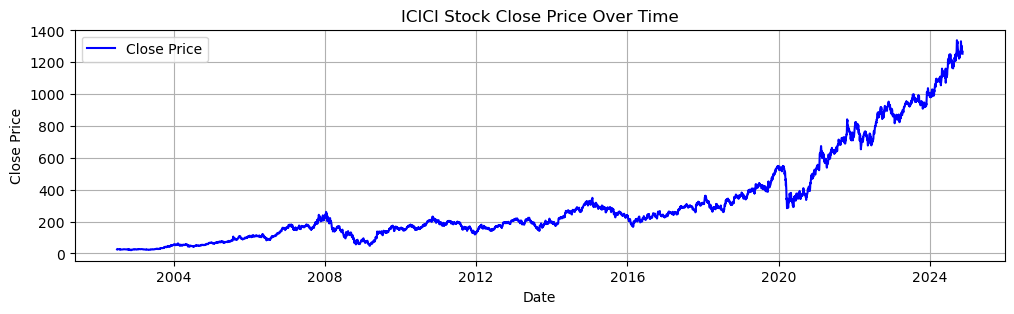

In [131]:
import matplotlib.pyplot as plt

# Convert to Pandas
pandas_df = df_icici.select("Date", "Close").orderBy("Date").toPandas()

# Plot
plt.figure(figsize=(12, 3))
plt.plot(pandas_df["Date"], pandas_df["Close"], label="Close Price", color='blue')
plt.title("ICICI Stock Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()


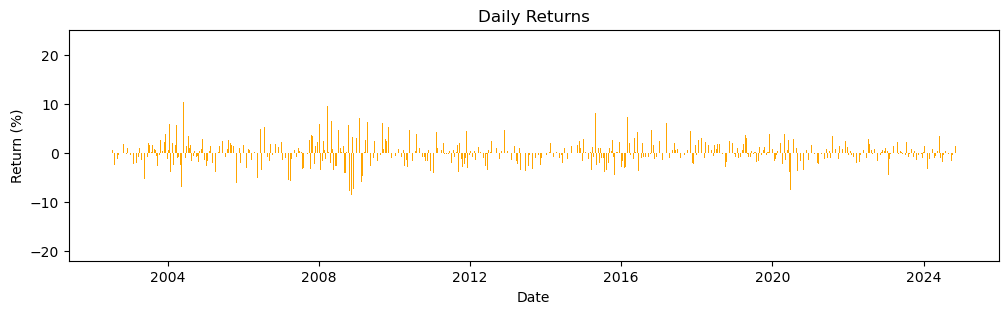

In [133]:
pandas_df = df_icici.select("Date", "Daily_Return").orderBy("Date").toPandas()

# Bar plot
plt.figure(figsize=(12, 3))
plt.bar(pandas_df["Date"], pandas_df["Daily_Return"], color='orange')
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.show()


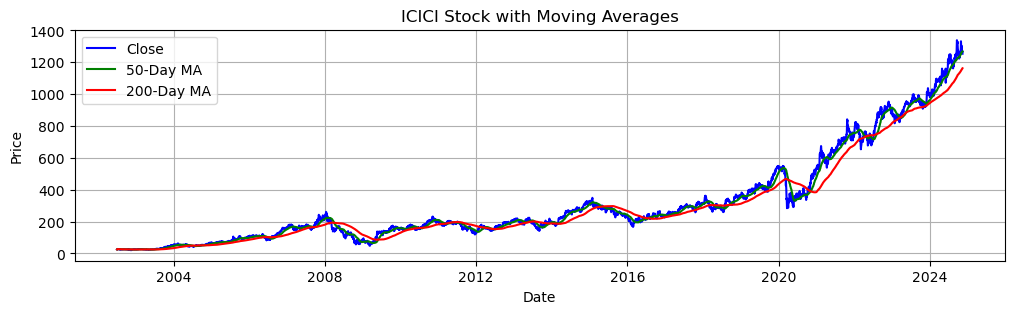

In [135]:
pandas_df = df_icici.select("Date", "Close", "Mov_Avg_50", "Mov_Avg_200").orderBy("Date").toPandas()

plt.figure(figsize=(12, 3))
plt.plot(pandas_df["Date"], pandas_df["Close"], label="Close", color='blue')
plt.plot(pandas_df["Date"], pandas_df["Mov_Avg_50"], label="50-Day MA", color='green')
plt.plot(pandas_df["Date"], pandas_df["Mov_Avg_200"], label="200-Day MA", color='red')
plt.title("ICICI Stock with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
